# Airbus Impact Project

In [1]:
# Imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import quantile, where, random
import datetime
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import pyplot as plt, dates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Import Datasets

In [2]:
filenames = ["data/msn_02_fuel_leak_signals_preprocessed.csv", 
             "data/msn_10_fuel_leak_signals_preprocessed.csv", 
             "data/msn_11_fuel_leak_signals_preprocessed.csv", 
             "data/msn_12_fuel_leak_signals_preprocessed.csv", 
             "data/msn_14_fuel_leak_signals_preprocessed.csv", 
             "data/msn_29_fuel_leak_signals_preprocessed.csv", 
             "data/msn_37_fuel_leak_signals_preprocessed.csv", 
             "data/msn_53_fuel_leak_signals_preprocessed.csv"]

datasets = []
datasets_labels = ["MSN_02", "MSN_10", "MSN_11", "MSN_12", "MSN_14", "MSN_29", "MSN_37", "MSN_53", "MSN_37_LEAK0.5", "MSN_37_LEAK1.0", "MSN_37_LEAK5.0"]
                   
for filename in filenames:
    datasets.append(pd.read_csv(filename, sep=";"))
    
for i in range(3):
    datasets.append(datasets[6].copy())
    
print("Datasets loaded")

Datasets loaded


Define Date and Time Columns

In [3]:
for dataset in datasets:
    #introduce column date
    dataset['UTC_TIME'] = pd.to_datetime(dataset['UTC_TIME'])
    dataset['DATE'] = dataset['UTC_TIME'].dt.date
    dataset["TIME"] = dataset['UTC_TIME'].dt.time

Check for Records and Features for every dataset

In [4]:
data = {}

data['Records'] = [dataset.shape[0] for dataset in datasets]
data['Features'] = [dataset.shape[1] for dataset in datasets]

pd.DataFrame(data, index = datasets_labels)

,Records,Features
MSN_02,623580,113
MSN_10,621610,19
MSN_11,4455992,19
MSN_12,3247664,19
MSN_14,4640993,19
MSN_29,4129447,19
MSN_37,3236645,19
MSN_53,3034227,19
MSN_37_LEAK0.5,3236645,19
MSN_37_LEAK1.0,3236645,19


Display columns in all datasets

In [5]:
for dataset in datasets:
    print(dataset.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623580 entries, 0 to 623579
Data columns (total 113 columns):
 #    Column                                Dtype         
---   ------                                -----         
 0    UTC_TIME                              datetime64[ns]
 1    MSN                                   object        
 2    Flight                                object        
 3    ENGINE_RUNNING_1                      bool          
 4    ENGINE_RUNNING_2                      bool          
 5    ENGINE_RUNNING_3                      bool          
 6    ENGINE_RUNNING_4                      bool          
 7    FLIGHT_PHASE_COUNT                    float64       
 8    FUEL_FLOW_1                           float64       
 9    FUEL_FLOW_2                           float64       
 10   FUEL_FLOW_3                           float64       
 11   FUEL_FLOW_4                           float64       
 12   FUEL_PITCH                            float64       
 13

Print Total Null values and relative Null values

In [6]:
pd.DataFrame({'NULL_VALUES': datasets[0].isnull().sum(), 'NULL_VALUES_%': datasets[0].isnull().sum() / datasets[0].shape[0] * 100, 'UNIQUE VALUES': datasets[0].nunique()})

,NULL_VALUES,NULL_VALUES_%,UNIQUE VALUES
UTC_TIME,0,0.000000,610106
MSN,0,0.000000,1
Flight,0,0.000000,42
ENGINE_RUNNING_1,0,0.000000,2
ENGINE_RUNNING_2,0,0.000000,2
...,...,...,...
STATUS_OVERFLOW_RST,63293,10.149941,1
VALUE_FUEL_VOL_LST,63265,10.145450,231657
VALUE_FUEL_VOL_RST,63275,10.147054,1636
DATE,0,0.000000,36


In [7]:
# Do the same for all datasets
df_feat = pd.DataFrame()

for i in range(1, len(datasets)):
    df_tmp = pd.DataFrame({f'{datasets_labels[i]}_miss': datasets[i].isnull().sum(), 
                           f'{datasets_labels[i]}_miss_%': datasets[i].isnull().sum() / datasets[i].shape[0] * 100, 
                           f'{datasets_labels[i]}_unique': datasets[i].nunique()})
    df_feat = pd.concat([df_feat, df_tmp], axis=1)
    
df_feat

,MSN_10_miss,MSN_10_miss_%,MSN_10_unique,MSN_11_miss,MSN_11_miss_%,MSN_11_unique,MSN_12_miss,MSN_12_miss_%,MSN_12_unique,MSN_14_miss,MSN_14_miss_%,MSN_14_unique,MSN_29_miss,MSN_29_miss_%,MSN_29_unique,MSN_37_miss,MSN_37_miss_%,MSN_37_unique,MSN_53_miss,MSN_53_miss_%,MSN_53_unique,MSN_37_LEAK0.5_miss,MSN_37_LEAK0.5_miss_%,MSN_37_LEAK0.5_unique,MSN_37_LEAK1.0_miss,MSN_37_LEAK1.0_miss_%,MSN_37_LEAK1.0_unique,MSN_37_LEAK5.0_miss,MSN_37_LEAK5.0_miss_%,MSN_37_LEAK5.0_unique
UTC_TIME,0,0.000000,621610,0,0.000000,4455992,0,0.000000,3247664,0,0.000000,4640993,0,0.000000,4129447,0,0.000000,3236645,0,0.000000,3034227,0,0.000000,3236645,0,0.000000,3236645,0,0.000000,3236645
FUEL_USED_2,562272,90.454143,167,4131081,92.708447,79193,3123512,96.177191,76080,4372059,94.205249,183458,3843623,93.078395,41312,2919211,90.192499,214755,2767417,91.206657,185876,2919211,90.192499,214755,2919211,90.192499,214755,2919211,90.192499,214755
FUEL_USED_3,560674,90.197069,46,4139824,92.904655,74411,3124135,96.196374,73428,4371649,94.196414,175370,3849617,93.223548,39139,2919569,90.203560,200718,2767748,91.217565,174609,2919569,90.203560,200718,2919569,90.203560,200718,2919569,90.203560,200718
FUEL_USED_4,565835,91.027332,280,4164851,93.466303,61768,3124839,96.218051,67163,4374096,94.249140,160715,3852202,93.286147,31568,2919530,90.202355,176854,2767042,91.194298,155882,2919530,90.202355,176854,2919530,90.202355,176854,2919530,90.202355,176854
FW_GEO_ALTITUDE,82937,13.342289,34301,300327,6.739846,36757,40360,1.242739,36710,65487,1.411056,36845,319525,7.737719,36983,73299,2.264660,35627,47079,1.551598,36721,73299,2.264660,35627,73299,2.264660,35627,73299,2.264660,35627
VALUE_FOB,82937,13.342289,40071,300327,6.739846,51763,40170,1.236889,43076,65487,1.411056,43874,319525,7.737719,43278,73129,2.259408,43025,47079,1.551598,44180,73129,2.259408,43025,73129,2.259408,43025,73129,2.259408,43025
VALUE_FUEL_QTY_CT,82937,13.342289,10980,300327,6.739846,11490,40170,1.236889,11305,65487,1.411056,11550,319525,7.737719,11500,73129,2.259408,10226,47079,1.551598,11774,73129,2.259408,10226,73129,2.259408,10226,73129,2.259408,10226
VALUE_FUEL_QTY_FT1,82937,13.342289,1007,300327,6.739846,1805,40170,1.236889,1425,65487,1.411056,1566,319525,7.737719,1139,73129,2.259408,1531,47079,1.551598,1360,73129,2.259408,1531,73129,2.259408,1531,73129,2.259408,1531
VALUE_FUEL_QTY_FT2,82937,13.342289,1366,300327,6.739846,2238,40170,1.236889,1877,65487,1.411056,2266,319525,7.737719,1725,73129,2.259408,1846,47079,1.551598,1807,73129,2.259408,1846,73129,2.259408,1846,73129,2.259408,1846
VALUE_FUEL_QTY_FT3,82937,13.342289,1162,300327,6.739846,2201,40170,1.236889,1939,65487,1.411056,2357,319525,7.737719,2021,73129,2.259408,1695,47079,1.551598,1831,73129,2.259408,1695,73129,2.259408,1695,73129,2.259408,1695


In [8]:
# print relative amount of flight phase 8
print("Relative amount of flight phases 3-11")
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].shape[0] / dataset.shape[0] * 100)
    
print("\nRelative amount of rows with NaN values in flight phases 3-11")
# count rows with NaN values in flight phases 3-11
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].isnull().any(axis=1).sum() / dataset.shape[0] * 100)


Relative amount of flight phases 3-11
70.66102184162418
76.78930519135793
83.32833631658225
87.78793003217082
88.45331160809766
82.0043458603537
87.88680871705114
88.84331989663265
87.88680871705114
87.88680871705114
87.88680871705114

Relative amount of rows with NaN values in flight phases 3-11
69.13691908015011
76.78930519135793
82.6928100409516
86.52459121386941
85.92697726542575
81.70161767423096
84.53345980173914
85.43022654534417
84.53345980173914
84.53345980173914
84.53345980173914


In [9]:
records_total = sum([dataset.shape[0] for dataset in datasets])
records_dropna = sum([dataset.dropna().shape[0] for dataset in datasets])

records_dropna_flightphase = {
    i: sum([dataset[dataset['FLIGHT_PHASE_COUNT'] == i].dropna().shape[0] for dataset in datasets])
    for i in range(1, 13)
}

print("Total records:", records_total)
print("Records after dropna:", records_dropna)
print("Records after dropna per flight phase:", records_dropna_flightphase)

Total records: 33700093
Records after dropna: 1664035
Records after dropna per flight phase: {1: 16973, 2: 897470, 3: 678, 4: 169, 5: 312, 6: 727, 7: 6479, 8: 670745, 9: 2677, 10: 241, 11: 64277, 12: 3287}


In [10]:
# Drop rows with duplicats in UTC_TIME
for dataset in datasets:
    dataset.drop_duplicates(subset=['UTC_TIME'], inplace=True)

In [11]:
df_tmp = pd.DataFrame(records_dropna_flightphase, index=['Records']).transpose()
 
fig = px.bar(df_tmp, x=df_tmp.index, y='Records', title='Records after dropna per flight phase')
fig.show()


In [12]:
for i, dataset in enumerate(datasets):
    df_tmp = dataset.dropna()
    flight_phase_count = df_tmp['FLIGHT_PHASE_COUNT'].value_counts()
    
    #plot bar chart for flight phase count
    fig = px.bar(flight_phase_count, x=flight_phase_count.index, y='FLIGHT_PHASE_COUNT', title=f'Flight phase count for {datasets_labels[i]}')
    fig.show()
    
    

Calculate std in tanks by flight-phase

In [13]:
datasets_dropna = [df.dropna() for df in datasets]
all_datasets = pd.concat(datasets_dropna, ignore_index=True)

columns_to_describe = [
    'FUEL_USED_1', 
    'FUEL_USED_2', 
    'FUEL_USED_3', 
    'FUEL_USED_4', 
    'VALUE_FUEL_QTY_CT', 
    'VALUE_FUEL_QTY_RXT', 
    'VALUE_FUEL_QTY_LXT', 
    'VALUE_FUEL_QTY_FT1', 
    'VALUE_FUEL_QTY_FT2', 
    'VALUE_FUEL_QTY_FT3', 
    'VALUE_FUEL_QTY_FT4'
]

std_df = all_datasets.groupby('FLIGHT_PHASE_COUNT')[columns_to_describe].std().reset_index()
std_df.columns = ['FLIGHT_PHASE'] + [f'{col}_std' for col in columns_to_describe]

Show Dataframe with lowest and highest value marked in green and red

In [14]:
# mark the highest value in each column red and lowest green and the middle yellow
def highlight_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    is_middle = s == s.median()
     
    return ['background-color: red' if v else 'background-color: green' if w else 'background-color: yellow' if x else '' for v, w, x in zip(is_max, is_min, is_middle)]
 
std_df.style.apply(highlight_max)

,FLIGHT_PHASE,FUEL_USED_1_std,FUEL_USED_2_std,FUEL_USED_3_std,FUEL_USED_4_std,VALUE_FUEL_QTY_CT_std,VALUE_FUEL_QTY_RXT_std,VALUE_FUEL_QTY_LXT_std,VALUE_FUEL_QTY_FT1_std,VALUE_FUEL_QTY_FT2_std,VALUE_FUEL_QTY_FT3_std,VALUE_FUEL_QTY_FT4_std
0,1.000000,2353.196652,2240.701518,2297.951546,2359.984179,2376.801624,3654.568886,3628.124599,208.557257,283.433299,319.882945,206.427462
1,2.000000,1745.874090,1721.084598,2010.287037,2323.769395,2525.560397,3667.582860,3640.608503,211.233616,268.829855,286.471373,221.481208
2,3.000000,146.335314,99.202357,100.283573,140.242805,2337.232059,4276.942092,4372.668106,227.772463,302.719726,320.798902,209.344301
3,4.000000,147.439491,149.554573,149.251474,148.056672,2755.701528,2925.806267,2937.427009,236.120781,325.478839,309.133687,213.712693
4,5.000000,266.164495,262.463931,263.139815,265.609818,2855.282415,3017.348274,3021.346821,223.271593,297.678269,268.645295,209.456919
5,6.000000,475.778113,473.955830,476.168311,480.847547,2581.540443,2795.743036,2794.200675,231.442074,304.801984,269.622426,247.671162
6,7.000000,516.367045,515.483464,519.424208,521.480579,2580.427172,3334.786097,3325.688243,209.071659,267.737811,251.903888,203.251074
7,8.000000,1731.908310,1720.663637,1737.942308,1743.915554,1780.275600,3291.662314,3304.582454,159.446487,213.538220,215.506590,161.947810
8,9.000000,1832.391659,1846.118873,1865.597209,1869.629623,92.569971,2498.294118,2514.095627,226.519334,389.095231,367.510071,207.482163
9,10.000000,1064.537656,1088.705524,1080.060667,1086.736541,98.500767,2682.550603,2699.194402,231.341476,405.854382,394.053467,250.140760


### Assign to each concetenated flight a unique flight number and only keep flight_phases 3 - 11

In [15]:
columns_where_to_drop_nan = datasets[2].columns

def introduce_flight_column(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    # Drop NaN values
    dataset_tmp = dataset_tmp.dropna(subset=columns_where_to_drop_nan)
    
    # Variable to store flight number
    flight_number = 0
    
    # assign flight number to rows that have indexes following each other
    # if the difference between two indexes is greater than 1, a new flight is assumed
    print(dataset_tmp.shape)
    
    for i in range(1, dataset_tmp.shape[0]):
        if dataset_tmp.index[i] - dataset_tmp.index[i-1] > 1:
            flight_number += 1
        dataset_tmp.at[dataset_tmp.index[i], 'FLIGHT'] = flight_number
        
    # Fill nan values in flight column with 0
    dataset_tmp['FLIGHT'] = dataset_tmp['FLIGHT'].fillna(0)
    
    # only keep rows with flight_phase_count between 3-11
    # dataset_tmp = dataset_tmp[(dataset_tmp['FLIGHT_PHASE_COUNT'] >= 3) & (dataset_tmp['FLIGHT_PHASE_COUNT'] <= 11)]
        
    # return dataset with flight column
    return dataset_tmp[dataset_tmp['FLIGHT_PHASE_COUNT'].isin(list(range(2,12)))]
   

## New Features

In [16]:
def define_new_features(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    dataset_tmp['TOTAL_FUEL_USED'] = 0
     
    # Total fuel column is the sum of all fuel used columns
    for i in range(1, 5):
        dataset_tmp['TOTAL_FUEL_USED'] += dataset_tmp['FUEL_USED_' + str(i)]
        
    # Get difference for VALUE_FOB. For each flight the first value must be 0
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].diff()
    
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp['VALUE_FOB_DIFF'].fillna(0)
    
    dataset_tmp['TOTAL_FOB_BY_QTY'] = dataset_tmp['VALUE_FUEL_QTY_CT'] + dataset_tmp['VALUE_FUEL_QTY_FT1'] + dataset_tmp['VALUE_FUEL_QTY_FT2'] + dataset_tmp['VALUE_FUEL_QTY_FT3'] + dataset_tmp['VALUE_FUEL_QTY_FT4'] + dataset_tmp['VALUE_FUEL_QTY_LXT'] + dataset_tmp['VALUE_FUEL_QTY_RXT']
    
    dataset_tmp['DELTA_VFOB_VS_VFOBQTY'] = dataset_tmp['VALUE_FOB'] - dataset_tmp['TOTAL_FOB_BY_QTY']
    
    dataset_tmp['ALTITUDE_DIFF'] = dataset_tmp['FW_GEO_ALTITUDE'].diff().abs()    
    
    # for each FLIGHT substract the first value of TOTAL_FUEL_USED from all values
    #for flight in dataset_tmp['FLIGHT'].unique():
    #    dataset_tmp.loc[dataset_tmp['FLIGHT'] == flight, 'TOTAL_FUEL_USED'] -= dataset_tmp[dataset_tmp['FLIGHT'] == flight]['TOTAL_FUEL_USED'].iloc[0]
   
    
    return dataset_tmp

Deleting Values before all Fuel_Used Columns are resetted

In [17]:
def subtract_first(x):
    return x.iloc[0] - x

def initalize_flights(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
     
    for flight_num in dataset_tmp['FLIGHT'].unique():
        # get first index of flight 
        first_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[0]
        
        # get last index of flight
        last_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[-1]
        
        # get location of min value of VALUE_FOB per flight 
        min_value_sum_fuel_used = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num]['TOTAL_FUEL_USED'].idxmin()
        
        # delete in dataset_tmp all rows between first_location and min_value_fob
        dataset_tmp.drop(dataset_tmp.loc[first_index:min_value_sum_fuel_used].index, inplace=True)
        
        # dataset_tmp["VALUE_FOB_MISSING"] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)
        
    return dataset_tmp

In [18]:
datasets_unique_flight = [introduce_flight_column(dataset) for dataset in datasets_dropna]

(28027, 113)
(24, 19)
(96431, 19)
(90540, 19)
(203932, 19)
(50138, 19)
(243326, 19)
(219761, 19)
(243326, 19)
(243326, 19)
(243326, 19)


In [19]:
datasets_with_new_features = [define_new_features(dataset) for dataset in datasets_unique_flight]

In [20]:
datasets_without_reset_engines = [initalize_flights(dataset) for dataset in datasets_with_new_features]

In [21]:
for dataset in datasets_without_reset_engines:
    dataset['VALUE_FOB_MISSING'] = dataset.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)

In [22]:
for i, dataset in enumerate(datasets_without_reset_engines):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Dataset 0 shape: (22255, 120)
Dataset 0 unique flights: 34
Dataset 1 shape: (23, 26)
Dataset 1 unique flights: 1
Dataset 2 shape: (64378, 26)
Dataset 2 unique flights: 428
Dataset 3 shape: (67862, 26)
Dataset 3 unique flights: 380
Dataset 4 shape: (162014, 26)
Dataset 4 unique flights: 849
Dataset 5 shape: (31431, 26)
Dataset 5 unique flights: 212
Dataset 6 shape: (175705, 26)
Dataset 6 unique flights: 1049
Dataset 7 shape: (158099, 26)
Dataset 7 unique flights: 931
Dataset 8 shape: (175705, 26)
Dataset 8 unique flights: 1049
Dataset 9 shape: (175705, 26)
Dataset 9 unique flights: 1049
Dataset 10 shape: (175705, 26)
Dataset 10 unique flights: 1049


Plot Altitude vs Value Fob for dataset 0

Plot Altitude vs Value Fob for the rest of the datasets

In [23]:
flight_phase_dict = {
    1: 'Pre-flight',
    2: 'Engine Run',
    3: 'Take-Off 1',
    4: 'Take-Off 2',
    5: 'Take-Off 3',
    6: 'Climbing 1',
    7: 'Climbing 2',
    8: 'Cruise',
    9: 'Descent',
    10: 'Approach',
    11: 'Landing',
    12: 'Post-flight'
}

def plot_flight(dataset, min_flight_length=100, max_graphs=10):
    for flight_num in dataset["FLIGHT"].unique(): 
        fig = go.Figure()

        # Define data for flight
        flight_data = dataset[dataset['FLIGHT'] == flight_num]
        
        if flight_data.shape[0] < min_flight_length:
            continue
        
        # Define traces
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['VALUE_FOB'],
                                mode='lines',
                                name='VALUE_FOB')) 

        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['FW_GEO_ALTITUDE'],
                                mode='lines',
                                name='FW_GEO_ALTITUDE'))
        
        # add trace for total_fuel_used
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['TOTAL_FUEL_USED'],
                                    mode='lines',
                                    name='TOTAL_FUEL_USED'))
        
        # add trace for VALUE_FOB_DIFF
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_DIFF'],
                                    mode='lines',
                                    name='VALUE_FOB_DIFF'))
        
        
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_MISSING'],
                                    mode='lines',
                                    name='VALUE_FOB_MISSING'))
        
        
        for flight_phase in flight_data['FLIGHT_PHASE_COUNT'].unique():
            fig.add_trace(go.Scatter(x=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['UTC_TIME'],
                                    y=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['VALUE_FOB'],
                                    mode='lines',
                                        name=f'{flight_phase}, {flight_phase_dict[flight_phase]}'))

        fig.update_layout(title=f'VALUE_FOB and FW_GEO_ALTITUDE for flight {flight_num}',
                        xaxis_title='UTC_TIME',
                        yaxis_title='VALUE_FOB and FW_GEO_ALTITUDE')
        
        # Define rectangles for different flight phases
        shapes = []
        colors = [
        'LightSkyBlue', 'LightSalmon', 'LightGreen', 'LightYellow', 'LightPink', 
        'MediumPurple', 'DarkOrange', 'MediumSeaGreen', 'DeepSkyBlue']
        # Define more colors if needed
        for i, flight_phase in enumerate(flight_data['FLIGHT_PHASE_COUNT'].unique()):
            phase_data = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]
            shapes.append(
                go.layout.Shape(
                    type="rect",
                    xref="x",
                    yref="paper",  # use 'paper' to refer to the entire y range
                    x0=phase_data['UTC_TIME'].min(),
                    x1=phase_data['UTC_TIME'].max(),
                    y0=0,
                    y1=1,
                    fillcolor=colors[i % len(colors)],
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                )
            )
        
        fig.update_layout(shapes=shapes)
        fig.show()
        
        max_graphs -= 1
        
        if(max_graphs == 0):    
            break
        
        


In [24]:
plot_flight(datasets_without_reset_engines[1], min_flight_length=500, max_graphs=3)

In [25]:
datasets_without_reset_engines[3]

,UTC_TIME,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,FLIGHT_PHASE_COUNT,FUEL_USED_1,Flight,MSN,DATE,TIME,FLIGHT,TOTAL_FUEL_USED,VALUE_FOB_DIFF,TOTAL_FOB_BY_QTY,DELTA_VFOB_VS_VFOBQTY,ALTITUDE_DIFF,VALUE_FOB_MISSING
1233790,2015-08-10 16:26:27,243.790207,2165.263184,235.294418,317.0,25718.0,0.0,2012.0,2704.0,2466.0,1751.0,8175.0,8611.0,2.0,281.037720,142.0,F-RBAE,2015-08-10,16:26:27,0.0,2925.385529,-1.0,25719.0,-1.0,0.0,0.0
1233791,2015-08-10 16:26:28,243.790207,2165.263184,235.294418,317.0,25720.0,0.0,2013.0,2704.0,2466.0,1751.0,8175.0,8611.0,2.0,281.037720,142.0,F-RBAE,2015-08-10,16:26:28,0.0,2925.385529,2.0,25720.0,0.0,0.0,-2.0
1233792,2015-08-10 16:26:29,243.790207,2165.263184,235.294418,317.0,25718.0,0.0,2013.0,2704.0,2466.0,1751.0,8176.0,8612.0,2.0,281.037720,142.0,F-RBAE,2015-08-10,16:26:29,0.0,2925.385529,-2.0,25722.0,-4.0,0.0,0.0
1233793,2015-08-10 16:26:30,243.790207,2165.263184,235.294418,317.0,25717.0,0.0,2013.0,2703.0,2466.0,1751.0,8176.0,8613.0,2.0,281.037720,142.0,F-RBAE,2015-08-10,16:26:30,0.0,2925.385529,-1.0,25722.0,-5.0,0.0,1.0
1233794,2015-08-10 16:26:31,243.790207,2165.263184,235.294418,317.0,25717.0,0.0,2013.0,2702.0,2465.0,1750.0,8176.0,8613.0,2.0,281.037720,142.0,F-RBAE,2015-08-10,16:26:31,0.0,2925.385529,0.0,25719.0,-2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3242059,2018-04-19 16:48:45,3472.485596,3489.308594,3574.129883,293.0,20805.0,0.0,1907.0,2675.0,2557.0,1886.0,5826.0,5957.0,11.0,3844.578125,503.0,F-RBAE,2018-04-19,16:48:45,380.0,14380.502197,3.0,20808.0,-3.0,0.0,75.0
3242060,2018-04-19 16:48:46,3472.570557,3489.406738,3574.217773,294.0,20809.0,0.0,1907.0,2675.0,2557.0,1886.0,5827.0,5960.0,11.0,3844.666992,503.0,F-RBAE,2018-04-19,16:48:46,380.0,14380.862061,4.0,20812.0,-3.0,1.0,71.0
3242061,2018-04-19 16:48:47,3472.655762,3489.494141,3574.316650,294.0,20815.0,0.0,1907.0,2675.0,2557.0,1886.0,5828.0,5965.0,11.0,3844.780518,503.0,F-RBAE,2018-04-19,16:48:47,380.0,14381.247070,6.0,20818.0,-3.0,0.0,65.0
3242062,2018-04-19 16:48:48,3472.741211,3489.592285,3574.404053,294.0,20818.0,0.0,1906.0,2675.0,2557.0,1886.0,5829.0,5968.0,11.0,3844.881348,503.0,F-RBAE,2018-04-19,16:48:48,380.0,14381.618896,3.0,20821.0,-3.0,0.0,62.0


## Bring all datasets to the same shape

In [26]:
# Define functions to drop so that all datasets have the same columns
columns_to_drop = [column for column in datasets_without_reset_engines[0].columns if column not in datasets_without_reset_engines[2].columns]

datasets_without_reset_engines[0].drop(columns_to_drop, axis=1, inplace=True) 

In [27]:
# shape of datasets
for i, dataset in enumerate(datasets_without_reset_engines):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Dataset 0 shape: (22255, 26)
Dataset 0 unique flights: 34
Dataset 1 shape: (23, 26)
Dataset 1 unique flights: 1
Dataset 2 shape: (64378, 26)
Dataset 2 unique flights: 428
Dataset 3 shape: (67862, 26)
Dataset 3 unique flights: 380
Dataset 4 shape: (162014, 26)
Dataset 4 unique flights: 849
Dataset 5 shape: (31431, 26)
Dataset 5 unique flights: 212
Dataset 6 shape: (175705, 26)
Dataset 6 unique flights: 1049
Dataset 7 shape: (158099, 26)
Dataset 7 unique flights: 931
Dataset 8 shape: (175705, 26)
Dataset 8 unique flights: 1049
Dataset 9 shape: (175705, 26)
Dataset 9 unique flights: 1049
Dataset 10 shape: (175705, 26)
Dataset 10 unique flights: 1049


# Dropping Outliers

In [28]:
# define all numeric columns
numeric_columns = ['FUEL_USED_2',
 'FUEL_USED_3',
 'FUEL_USED_4',
 'FW_GEO_ALTITUDE',
 'VALUE_FOB',
 'VALUE_FUEL_QTY_CT',
 'VALUE_FUEL_QTY_FT1',
 'VALUE_FUEL_QTY_FT2',
 'VALUE_FUEL_QTY_FT3',
 'VALUE_FUEL_QTY_FT4',
 'VALUE_FUEL_QTY_LXT',
 'VALUE_FUEL_QTY_RXT',
 'FLIGHT_PHASE_COUNT',
 'FUEL_USED_1',
 'TOTAL_FUEL_USED',
 'VALUE_FOB_DIFF',
 'TOTAL_FOB_BY_QTY',
 'DELTA_VFOB_VS_VFOBQTY',
 'ALTITUDE_DIFF',
 'VALUE_FOB_MISSING']

# function to drop outliers greater than 3 standard deviations for all columns
def drop_outliers(dataset):
    return dataset[(np.abs(stats.zscore(dataset[numeric_columns])) < 3).all(axis=1)]

In [29]:
datasets_without_outliers = [drop_outliers(dataset) for dataset in datasets_without_reset_engines]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# remove second dataset from list as it has not enough data
datasets_without_outliers.pop(1)

,UTC_TIME,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,FLIGHT_PHASE_COUNT,FUEL_USED_1,Flight,MSN,DATE,TIME,FLIGHT,TOTAL_FUEL_USED,VALUE_FOB_DIFF,TOTAL_FOB_BY_QTY,DELTA_VFOB_VS_VFOBQTY,ALTITUDE_DIFF,VALUE_FOB_MISSING


In [31]:
datasets_without_outliers

[                  UTC_TIME         MSN Flight  FLIGHT_PHASE_COUNT  \
 33796  2016-10-07 07:38:15  A400M-0002  V0926                 2.0   
 33797  2016-10-07 07:38:16  A400M-0002  V0926                 2.0   
 33798  2016-10-07 07:38:17  A400M-0002  V0926                 2.0   
 33799  2016-10-07 07:38:18  A400M-0002  V0926                 2.0   
 33800  2016-10-07 07:38:19  A400M-0002  V0926                 2.0   
 ...                    ...         ...    ...                 ...   
 595495 2016-10-07 13:52:50  A400M-0002  V0927                11.0   
 595496 2016-10-07 13:52:51  A400M-0002  V0927                11.0   
 595497 2016-10-07 13:52:52  A400M-0002  V0927                11.0   
 595498 2016-10-07 13:52:53  A400M-0002  V0927                11.0   
 595499 2016-10-07 13:52:54  A400M-0002  V0927                11.0   
 
         FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
 33796      6.417926     2.685516     0.002914        0.000         539.1815  

## Merge all datasets

In [65]:
# merge all datasets into one
merged_dataset = pd.concat(datasets_without_outliers)

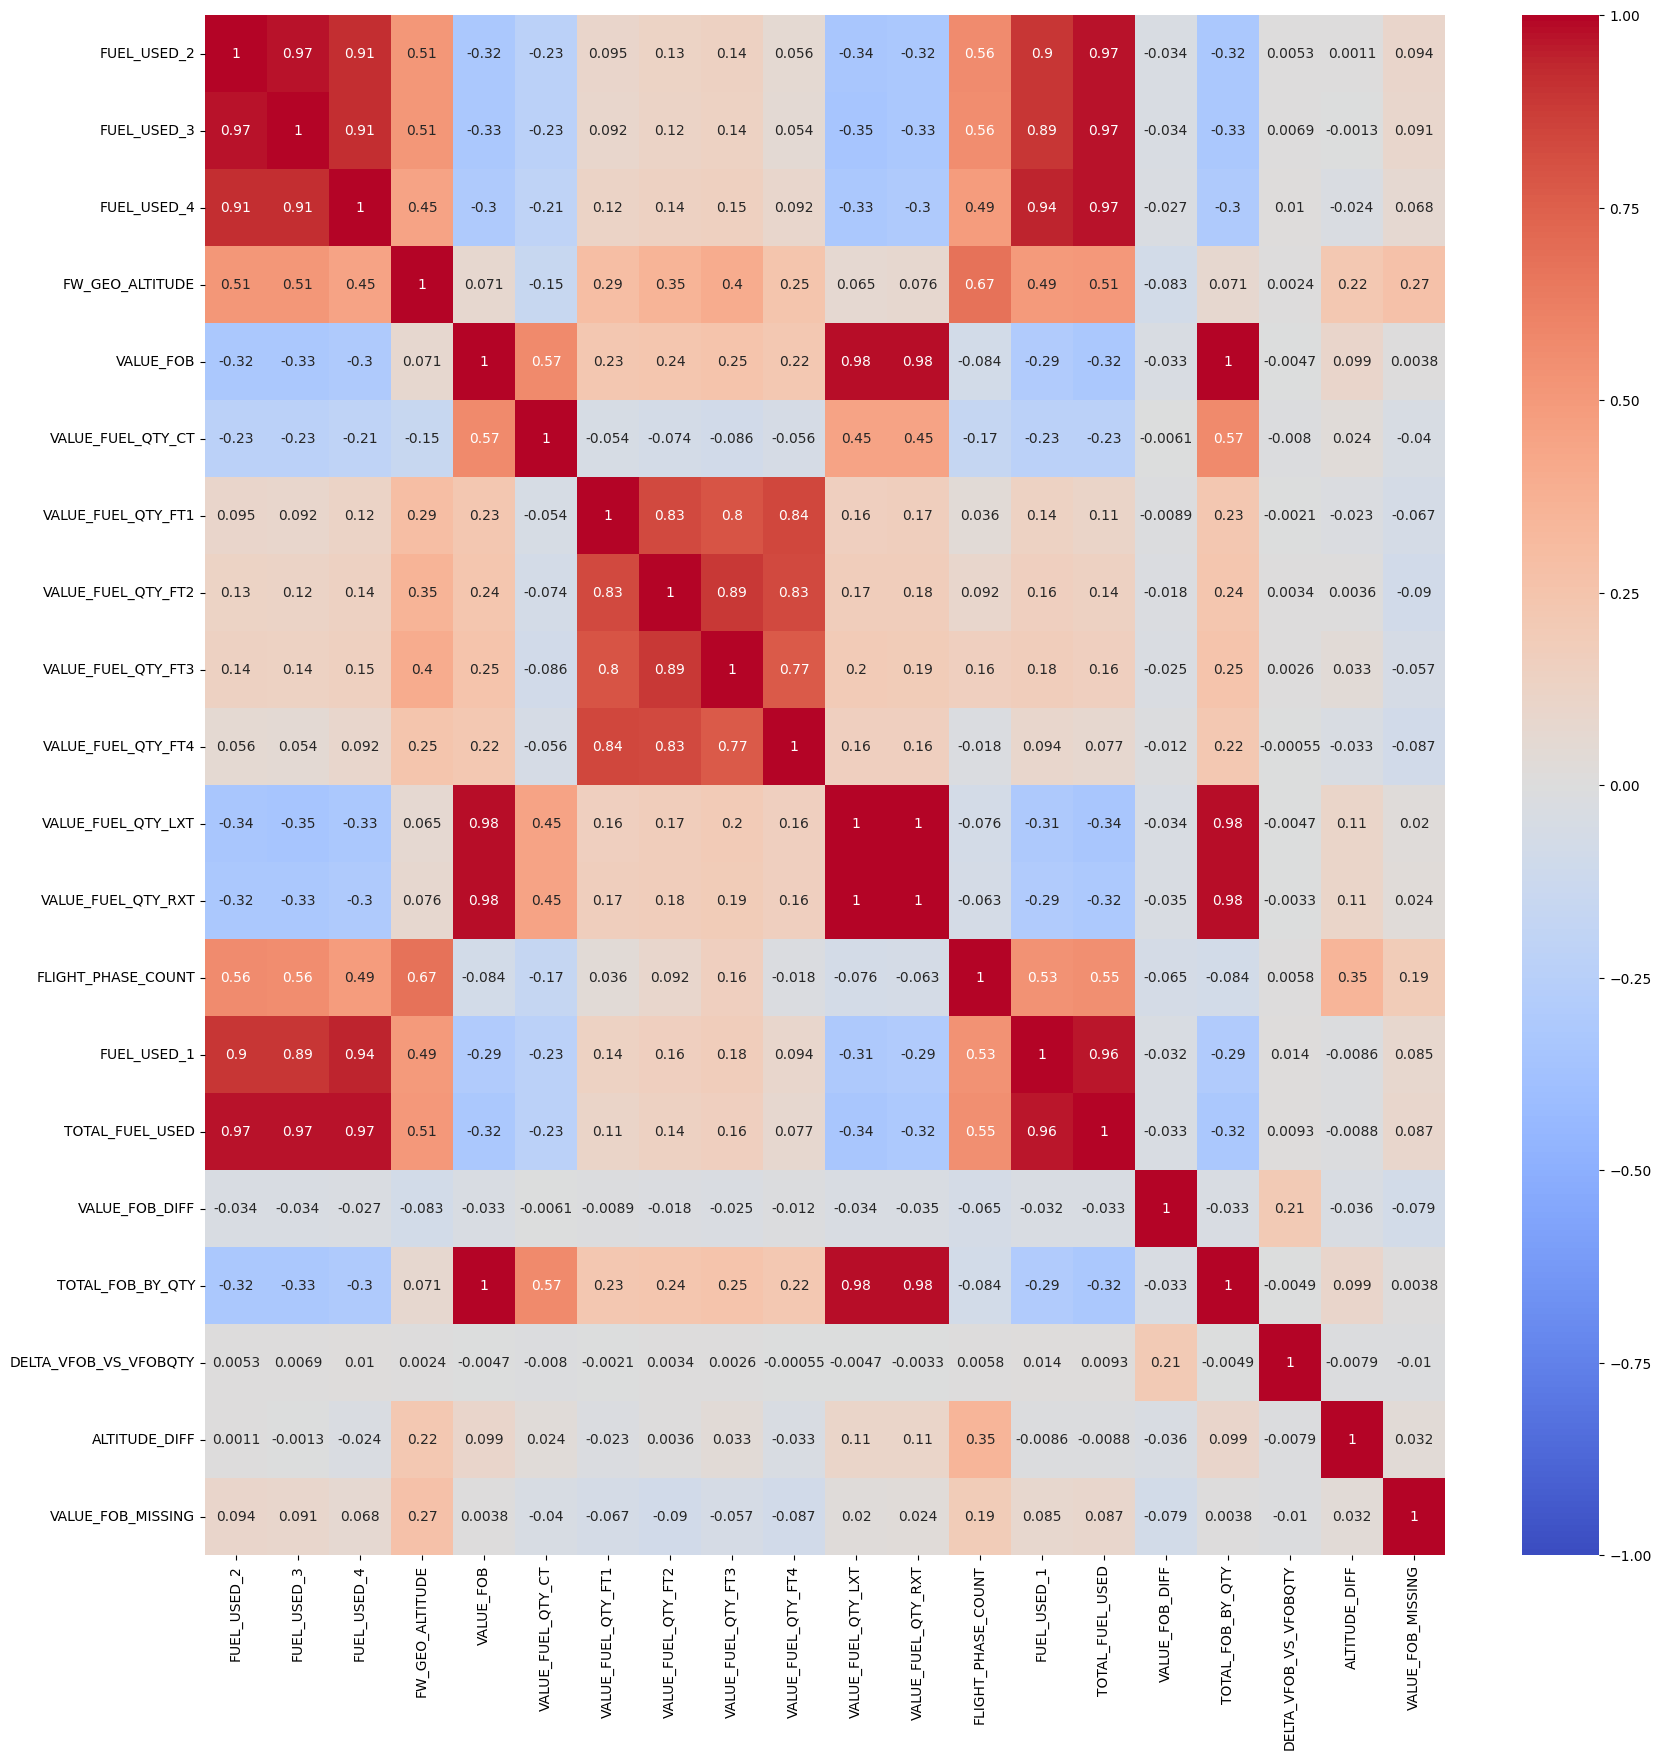

In [66]:
import seaborn as sns

# heatmap for numeric columns
fig = plt.figure(figsize=(20, 20))
sns.heatmap(merged_dataset[numeric_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [34]:
merged_dataset

,UTC_TIME,MSN,Flight,FLIGHT_PHASE_COUNT,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,DATE,TIME,FLIGHT,TOTAL_FUEL_USED,VALUE_FOB_DIFF,TOTAL_FOB_BY_QTY,DELTA_VFOB_VS_VFOBQTY,ALTITUDE_DIFF,VALUE_FOB_MISSING
33796,2016-10-07 07:38:15,A400M-0002,V0926,2.0,6.417926,2.685516,0.002914,0.000000,539.1815,17915.0,0.0,1949.0,2529.0,2588.0,1929.0,4587.0,4335.0,2016-10-07,07:38:15,0.0,9.106356,-1.0,17917.0,-2.0,0.0075,0.0
33797,2016-10-07 07:38:16,A400M-0002,V0926,2.0,6.519280,2.784187,0.003221,0.000000,539.0031,17914.0,0.0,1949.0,2529.0,2588.0,1929.0,4586.0,4335.0,2016-10-07,07:38:16,0.0,9.306688,-1.0,17916.0,-2.0,0.1784,1.0
33798,2016-10-07 07:38:17,A400M-0002,V0926,2.0,6.620632,2.883186,0.003584,0.000000,539.0146,17915.0,0.0,1949.0,2529.0,2588.0,1929.0,4586.0,4336.0,2016-10-07,07:38:17,0.0,9.507402,1.0,17917.0,-2.0,0.0115,0.0
33799,2016-10-07 07:38:18,A400M-0002,V0926,2.0,6.721996,2.982092,0.003665,0.000000,539.0156,17915.0,0.0,1948.0,2528.0,2588.0,1929.0,4586.0,4336.0,2016-10-07,07:38:18,0.0,9.707753,0.0,17915.0,0.0,0.0010,0.0
33800,2016-10-07 07:38:19,A400M-0002,V0926,2.0,6.823327,3.081056,0.003076,0.000000,539.0253,17915.0,0.0,1948.0,2528.0,2588.0,1929.0,4586.0,4337.0,2016-10-07,07:38:19,0.0,9.907459,0.0,17916.0,-1.0,0.0097,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212289,2018-04-01 07:25:55,F-RBAJ,497.0,2.0,16.738115,14.168570,11.232055,8.402565,1048.0000,38303.0,4722.0,1904.0,2585.0,2451.0,1907.0,12326.0,12411.0,2018-04-01,07:25:55,1049.0,50.541305,-6.0,38306.0,-3.0,0.0000,33.0
3212290,2018-04-01 07:25:56,F-RBAJ,497.0,2.0,16.854839,14.276997,11.351117,8.523571,1047.0000,38296.0,4719.0,1904.0,2584.0,2451.0,1907.0,12322.0,12412.0,2018-04-01,07:25:56,1049.0,51.006524,-7.0,38299.0,-3.0,1.0000,40.0
3212291,2018-04-01 07:25:57,F-RBAJ,497.0,2.0,16.958508,14.398455,11.443074,8.617579,1047.0000,38289.0,4719.0,1903.0,2583.0,2452.0,1906.0,12318.0,12412.0,2018-04-01,07:25:57,1049.0,51.417616,-7.0,38293.0,-4.0,0.0000,47.0
3212292,2018-04-01 07:25:58,F-RBAJ,497.0,2.0,17.062273,14.506254,11.562201,8.738839,1048.0000,38289.0,4720.0,1905.0,2582.0,2452.0,1905.0,12318.0,12411.0,2018-04-01,07:25:58,1049.0,51.869567,0.0,38293.0,-4.0,1.0000,47.0


In [46]:
merged_dataset.to_csv('generated_data/merged_dataset_without_leakage.csv', index=False)

In [54]:
#merged_dataset_resampled_5s = merged_dataset.resample('5S', on='UTC_TIME').mean().dropna()

## Get Derivated Dataset

In [71]:
# new dataset with resampled data diff for numeric  columns
merged_dataset_diff = pd.DataFrame()
 
for columns in numeric_columns:
    merged_dataset_diff[columns] = merged_dataset[columns].diff()
    
# fillna with 0
merged_dataset_diff.fillna(0, inplace=True)

## Scaling

In [76]:
# define scaler
scaler = StandardScaler()
 
# fit_transform on merged dataset
scaled_data = scaler.fit_transform(merged_dataset[numeric_columns])

# convert scaled_dataset to dataframe
scaled_dataset = pd.DataFrame(scaled_data, columns=numeric_columns)

scaled_dataset

,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,FLIGHT_PHASE_COUNT,FUEL_USED_1,TOTAL_FUEL_USED,VALUE_FOB_DIFF,TOTAL_FOB_BY_QTY,DELTA_VFOB_VS_VFOBQTY,ALTITUDE_DIFF,VALUE_FOB_MISSING
0,-0.800963,-0.804636,-0.819411,-0.963745,-0.707146,-0.410997,0.840304,0.349473,0.636925,0.656082,-0.765440,-0.814841,-1.221527,-0.808232,-0.833425,-0.027240,-0.707153,0.044966,-0.581304,-0.572296
1,-0.800903,-0.804636,-0.819411,-0.963757,-0.707273,-0.410997,0.840304,0.349473,0.636925,0.656082,-0.765727,-0.814841,-1.221527,-0.808171,-0.833394,-0.027240,-0.707279,0.044966,-0.556899,-0.567443
2,-0.800843,-0.804635,-0.819411,-0.963757,-0.707146,-0.410997,0.840304,0.349473,0.636925,0.656082,-0.765727,-0.814554,-1.221527,-0.808110,-0.833363,0.431685,-0.707153,0.044966,-0.580733,-0.572296
3,-0.800782,-0.804635,-0.819411,-0.963756,-0.707146,-0.410997,0.834845,0.345347,0.636925,0.656082,-0.765727,-0.814554,-1.221527,-0.808049,-0.833332,0.202223,-0.707406,1.635578,-0.582232,-0.572296
4,-0.800721,-0.804636,-0.819411,-0.963756,-0.707146,-0.410997,0.834845,0.345347,0.636925,0.656082,-0.765727,-0.814267,-1.221527,-0.807988,-0.833301,0.202223,-0.707279,0.840272,-0.580990,-0.572296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079560,-0.793938,-0.797828,-0.814488,-0.929325,1.873346,2.791324,0.594625,0.580482,0.096264,0.539884,1.457516,1.501888,-1.221527,-0.802026,-0.827005,-1.174552,1.873464,-0.750340,-0.582375,-0.412129
1079561,-0.793872,-0.797756,-0.814417,-0.929393,1.872460,2.789289,0.594625,0.576357,0.096264,0.539884,1.456367,1.502175,-1.221527,-0.801956,-0.826933,-1.404015,1.872578,-0.750340,-0.439570,-0.378154
1079562,-0.793798,-0.797700,-0.814362,-0.929393,1.871574,2.789289,0.589166,0.572232,0.100210,0.534602,1.455218,1.502175,-1.221527,-0.801894,-0.826869,-1.404015,1.871818,-1.545646,-0.582375,-0.344179
1079563,-0.793732,-0.797628,-0.814291,-0.929325,1.871574,2.789968,0.600085,0.568107,0.100210,0.529321,1.455218,1.501888,-1.221527,-0.801831,-0.826799,0.202223,1.871818,-1.545646,-0.439570,-0.344179


In [73]:
np.mean(scaled_data),np.std(scaled_data)

(-1.0098050532760266e-18, 1.0000000000000002)

In [45]:
# save scaled dataset to csv
scaled_dataset.to_csv('generated_data/scaled_dataset_without_leakage.csv', index=False)

## PCA without Synthetic Leak Data

In [39]:
scaled_data = pd.read_csv('generated_data/scaled_dataset_without_leakage.csv')

In [74]:
num_components = 15

# Create a PCA instance
pca = PCA(n_components=num_components)  

# Fit PCA on scaled_data
pca.fit(scaled_data)
 
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
 
# transform data 
pca_data = pca.transform(scaled_data)
 
# convert pca_data to dataframe
pca_dataset = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, num_components+1)])

[[ 3.11236069e-01  3.10595710e-01  2.87871295e-01  1.19204436e-01
  -3.08563519e-01 -1.81712653e-01 -1.36541150e-01 -1.25422269e-01
  -9.91369328e-02 -1.48709279e-01 -3.02591923e-01 -2.99917057e-01
   2.33542661e-01  2.88080697e-01  3.16674471e-01 -4.15651350e-03
  -3.08565559e-01  1.65694254e-03  1.63211282e-02 -1.44390838e-02]
 [ 1.90417025e-01  1.84186864e-01  2.38711483e-01  1.60929532e-01
   1.29326267e-01  1.48444718e-02  4.04914511e-01  4.47309496e-01
   4.15764395e-01  3.77010642e-01  9.97339407e-02  1.05404335e-01
   2.62729509e-02  2.43455555e-01  2.27365793e-01  1.53198413e-02
   1.29342321e-01 -6.88640189e-03 -5.65323290e-03 -3.45586208e-02]
 [-1.55041333e-01 -1.59185915e-01 -1.76500686e-01 -2.49002316e-01
  -3.22189191e-01 -3.18020626e-01  2.19978668e-01  2.25114717e-01
   2.13611431e-01  2.55993062e-01 -3.18651767e-01 -3.24457258e-01
  -2.28647359e-01 -1.64008030e-01 -1.73445158e-01  2.58431867e-02
  -3.22201321e-01  5.80412227e-03 -5.75874214e-02 -1.35611053e-01]
 [-3.44

In [44]:
pca_dataset.to_csv('generated_data/pca_dataset_without_leakage.csv', index=False)

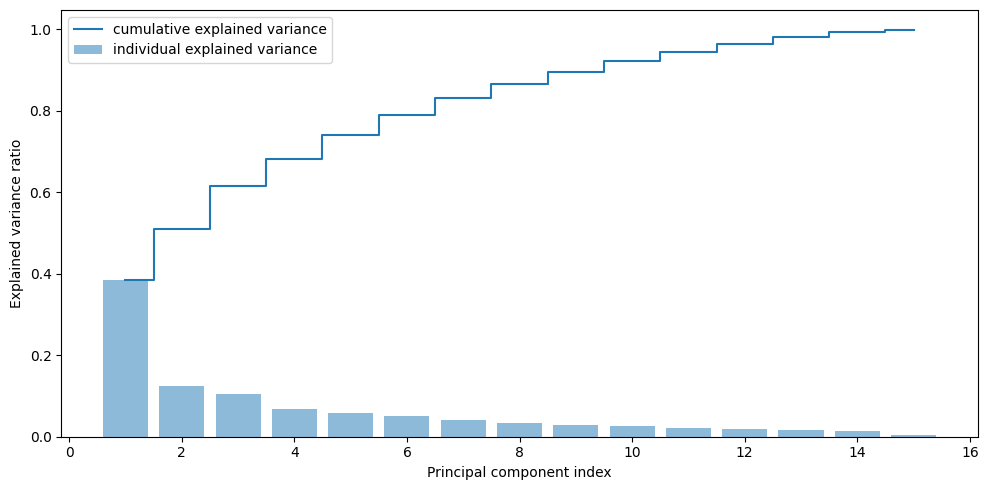

In [75]:
# plot percentage and cumulative percentage of variance explained by each principal component 
fig = plt.figure(figsize=(10, 5))
plt.bar(range(1, num_components+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, num_components+1), pca.explained_variance_ratio_.cumsum(), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

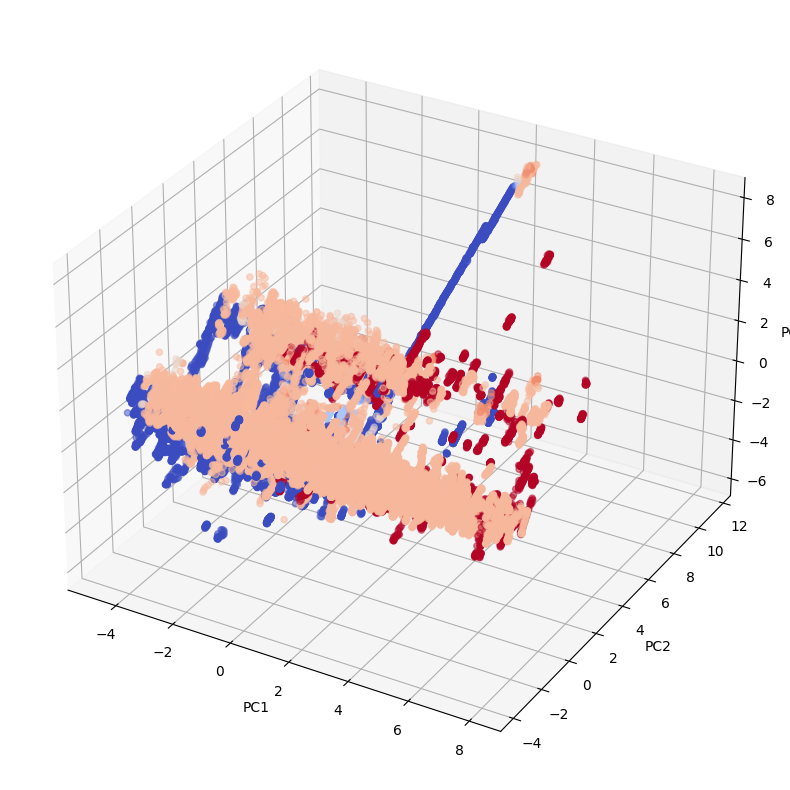

In [64]:
# 3d plot of first 3 principal components in different colors
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_dataset['PC1'], pca_dataset['PC2'], pca_dataset['PC3'], c=merged_dataset['FLIGHT_PHASE_COUNT'], cmap='coolwarm', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()



## PCA with Leakage

## Testing


In [ ]:
# in df_test plot TOTAL_FUEL_USED for each flight
for flight in df_test['FLIGHT'].unique():
    # count number of rows for each flight
    if df_test[df_test['FLIGHT'] == flight].shape[0] > 1:
        # plot TOTAL_FUEL_USED for each flight x = UTC_TIME, y = TOTAL_FUEL_USED only plot if FLIGHT_PHASE_COUNT == 8
        if df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].iloc[0] == 2:
            plt.plot(df_test[df_test['FLIGHT'] == flight]['UTC_TIME'], df_test[df_test['FLIGHT'] == flight]['VALUE_FOB_DIFF'])
            plt.show()

In [ ]:
# for each flight and each flightphase calculate the std of VALUE_FOB_DIFF 

results = []
for flight in df_test['FLIGHT'].unique():
    result = {}
    for flightphase in df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].unique():
        result['FLIGHT'] = flight
        result['FLIGHT_PHASE'] = flightphase
        result['VALUE_FOB_DIFF_std'] = df_test[(df_test['FLIGHT'] == flight) & (df_test['FLIGHT_PHASE_COUNT'] == flightphase)]['VALUE_FOB_DIFF'].std()
        results.append(result)
        
results_df = pd.DataFrame(results)

pd.pivot_table(results_df, values='VALUE_FOB_DIFF_std', index=['FLIGHT'], columns=['FLIGHT_PHASE'], aggfunc=np.sum,  fill_value=0).sort_values(by=[11], ascending=False)


In [ ]:
# plot for dataset 0 for column LEAK_DETECTION_LEAK_FLOW
datasets[0].plot.scatter(x='UTC_TIME', y='LEAK_DETECTION_LEAK_FLOW')

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Extract numeric part from 'Flight' column
datasets[0]['Flight_number'] = datasets[0]['Flight'].str.extract('(\d+)').astype(int)

# Sort DataFrame by 'Flight_number'
sorted_df = datasets[0].sort_values(by='Flight_number')

fig = go.Figure()

# boxplot for sorted DataFrame for column VALUE_FOB.
fig.add_trace(go.Box(
    x= sorted_df['Flight'], 
    y= sorted_df['VALUE_FOB'], 
    name= 'VALUE_FOB',
    line=dict(color='green'),  # change boxplot color to green
    marker=dict(color='green') # change marker color to green
))

# Calculate mean for each flight in the sorted DataFrame
mean_fob = sorted_df.groupby('Flight')['VALUE_FOB'].mean()

# Add a scatter plot for the mean values
fig.add_trace(go.Scatter(
    x=mean_fob.index, 
    y=mean_fob.values, 
    mode='lines', 
    name='Mean',
    line=dict(color='purple')  # set line color to purple
))

fig.update_layout(
    title_text="Boxplot for sorted dataset for column VALUE_FOB", 
    xaxis_title="Flight", 
    yaxis_title="VALUE_FOB",
    plot_bgcolor='black',  # set plot background color to black
    paper_bgcolor='black',  # set paper background color to black
    font=dict(color='white'),  # set font color to white
    autosize=False,
    width=1000,
    height=600
)

fig.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cat_features02 = [col for col in datasets[0] if datasets[0][col].dtypes.name == 'bool']
features02 = [col for col in datasets[0] if col not in cat_features02 if 'STATUS' not in col if 'MODE' not in col if col not in ["day", "month", "time", "year", "SELECTED_GADIR_ALTITUDE_VALUE", "VALUE_FUEL_VOL_LST", "VALUE_FUEL_VOL_RST", "FLIGHT_PHASE_COUNT", "APU_FUEL_FLOW_REQUEST_SIGNAL_1"]]

fig, ax = plt.subplots(figsize=(30,25)) 
sns.heatmap(msn02_smooth[features02].corr(), cmap="RdBu", annot=True, ax=ax)
plt.xticks(rotation=45, ha='right')


In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

def plot_datasets(dataset):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for date in dataset['DATE'].unique():
        for flight in dataset['MSN'].unique():
            # Create a subplot
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig 
            fig.update_layout(height=1400, width=1400)

            # Loop over each column
            for i, col in enumerate(fuel_qty_cols):
                # save the dataset for the current date and flight
                dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight)]
                # Add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # Update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

            # Show the plot
            #fig.show()
            
            # save the plot as png
            fig.write_image("plots2/" + str(date) +"-" + str(flight) + ".png")
     
            
#plot_datasets(datasets[1])

#for i in range(len(datasets)):
 #   if i > 1:
  #      plot_datasets(datasets[i])

In [ ]:
def plot_dataset_for_date(dataset, date, flight_phase):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for flight in dataset['MSN'].unique():
        # Create a subplot
        fig = sp.make_subplots(rows=3, cols=3)

        # size of fig 
        fig.update_layout(height=1000, width=1200)

        # Loop over each column
        for i, col in enumerate(fuel_qty_cols):
            # save the dataset for the current date and flight
            dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight) & (dataset['FLIGHT_PHASE_COUNT'] == flight_phase)]
            # Add scatter plot to subplot

            fig.add_trace(
                go.Scatter(x=dataset_tmp['UTC_TIME'], 
                        y=dataset_tmp[col], 
                        mode='markers',
                        name=col),
                row=i//3 + 1, 
                col=i%3 + 1
            )

            # Update xaxis and yaxis titles
            fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
            fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

    # Show the plot
    fig.show()

In [ ]:
plot_dataset_for_date(datasets[1], datetime.date(2015, 3, 7), 8.0)

In [ ]:
datasets[6][['DATE', 'MSN', 'FLIGHT_PHASE_COUNT']][datasets[6]['FLIGHT_PHASE_COUNT'] == 8.0]

In [ ]:
# function to add leakage data to the dataset
def add_leakage_data(dataset, leakage_qty):
    # substract leakage_qty from VALUE_FOB col
    dataset['VALUE_FOB'] = dataset['VALUE_FOB'] - (leakage_qty / 60)
    
    # add column FUEL_USED_BY_FOB to dataset
    # first column is 0 because we don't know the fuel used at the start of the flight
    # every next row is the row + difference between the current and previous row in VALUE_FOB
    dataset['FUEL_USED_BY_FOB'] = 0
    for i in range(1, dataset.shape[0]):
        dataset['FUEL_USED_BY_FOB'].iloc[i] = dataset['FUEL_USED_BY_FOB'].iloc[i-1] + (dataset['VALUE_FOB'].iloc[i] - dataset['VALUE_FOB'].iloc[i-1])
    
        

In [ ]:
add_leakage_data(datasets[8], 0.5)
add_leakage_data(datasets[9], 1.0)
add_leakage_data(datasets[10], 5.0)

In [ ]:
def relative_fuel_used(dataset):
    nulls = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0]["FUEL_USED_1"].isnull().sum()
    shape_0 = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0].shape[0]
    
    print(f"dataset_{1}", nulls / shape_0)
    
for dataset in datasets:
    relative_fuel_used(dataset)

In [ ]:
# plot for dataset 6 for 2016-07-27, flightphase 8
# plot columns VALUE_FOB and FUEL_USED_BY_FOB
dataste_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8.0) & (datasets[0]['DATE'] == datetime.date(2011, 3, 9))]

dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB'] - (5.0)

dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["FUEL_USED_1"] + dataste_tmp["FUEL_USED_2"] + dataste_tmp["FUEL_USED_3"] + dataste_tmp["FUEL_USED_4"]
dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["TOTAL_CONSUMPTION"] - dataste_tmp["TOTAL_CONSUMPTION"].iloc[0]

# invert the values of VALUE_FOB_LEAKAGE so that the highest value is 0
dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB_LEAKAGE'].max() - dataste_tmp['VALUE_FOB_LEAKAGE'] + 5.0

dataste_tmp['VALUE_FOB'] = dataste_tmp['VALUE_FOB'].max() - dataste_tmp['VALUE_FOB']


fig = go.Figure()

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
            y=dataste_tmp['TOTAL_CONSUMPTION'],
            name='TOTAL_CONSUMPTION')
)


fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB_LEAKAGE'],
                name='VALUE_FOB_LEAKAGE')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB'],
                name='VALUE_FOB')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['FW_GEO_ALTITUDE'],
                name='FW_GEO_ALTITUDE')
)

fig.show()

In [ ]:
# introduce new columns for each dataset [CT_DIFF, LXT_DIFF, RXT_DIFF, FT1_DIFF, FT2_DIFF, FT3_DIFF, FT4_DIFF]
# value represents the difference between the current and the previous value
for dataset in datasets:
    dataset['CT_DIFF'] = dataset['VALUE_FUEL_QTY_CT'].diff()
    dataset['LXT_DIFF'] = dataset['VALUE_FUEL_QTY_LXT'].diff()
    dataset['RXT_DIFF'] = dataset['VALUE_FUEL_QTY_RXT'].diff()
    dataset['FT1_DIFF'] = dataset['VALUE_FUEL_QTY_FT1'].diff()
    dataset['FT2_DIFF'] = dataset['VALUE_FUEL_QTY_FT2'].diff()
    dataset['FT3_DIFF'] = dataset['VALUE_FUEL_QTY_FT3'].diff()
    dataset['FT4_DIFF'] = dataset['VALUE_FUEL_QTY_FT4'].diff()  

In [ ]:
datasets[0].head()

In [ ]:
def plot_diff(): 
    #plot diff columns for dataset 0 for each unique date
    for date in datasets[0]['DATE'].unique():
        for flight in datasets[0]['MSN'].unique():
            # create subplot 3 columns and len(datasets[0].unique) rows
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig
            fig.update_layout(height=1000, width=1000)
            
            diff_cols = ['CT_DIFF', 'LXT_DIFF', 'RXT_DIFF', 'FT1_DIFF', 'FT2_DIFF', 'FT3_DIFF', 'FT4_DIFF']
            
            # loop over the diff columns
            for i, col in enumerate(diff_cols):
                # save the dataset for the current date and flight
                dataset_tmp = datasets[0][(datasets[0]['DATE'] == date) & (datasets[0]['MSN'] == flight)]
                # add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)
                
            # save fig as png 
            fig.write_image("plots2/diff_plots/" + str(date) + "-" + str(flight) + "_diff.png")

In [ ]:
# ideas
# 1. use lower bound and upper bound to detect outliers
# 2. use the bounds to plot the data and see if there are any outliers
# 3. deep learning auto detection anomaly detection

In [ ]:
# function to generate synthetic data for each dataset including a simulated fuel leak
# using 0,5l, 1L and 5L as the leak size per minute

def generate_synthetic_data(dataset, leak_size):
    # create a copy of the dataset
    synthetic_dataset = dataset.copy()
    
    synthetic_dataset['VALUE_FUEL_QTY_LXT'] = synthetic_dataset['VALUE_FUEL_QTY_LXT'] - (leak_size)
    
    return synthetic_dataset

## Calculate the fuel on board and the Fuel Used

In [ ]:
def calculate_fuel_used(dataset):
    fuel_used_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

    # save the sum of the fuel used columns in a new column
    dataset['FUEL_USED_SUM'] = dataset[fuel_used_cols].sum(axis=1)

    fuel_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']
    
    dataset['FUEL_COLS_SUM'] = dataset[fuel_cols].sum(axis=1)

    #datasets[0]['FUEL_DIFF_SUM'] = datasets[0]['FUEL_DIFF_SUM'].cumsum()

    # substract from each value in FUEL_COLS_SUM the first value bigger than 1 and get the absoulte value. Do this for each day
    dataset['FUEL_COLS_SUM'] = dataset.groupby(['DATE'])['FUEL_COLS_SUM'].transform(lambda x: x - x[x > 1].iloc[0]).abs()

    return dataset

In [ ]:
import datetime 

datasets[0][datasets[0]['DATE'] == datetime.date(2011, 3, 3)]

In [ ]:
import plotly.graph_objs as go

def plot_fuel_cons_vs_fuel_qty(dataset):
    # plot the fuel_used columns for dataset 0 for 2010-10-26
    fig = go.Figure()
    
    dates_to_find = dataset['DATE'].unique()[:1]

    for date in dates_to_find:
        dataset = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8]
        # plot FUEL_USED_SUM and FUEL_DIFF_SUM
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_USED_SUM'],
                                    name='FUEL_USED_SUM'))
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_COLS_SUM'],
                                    name='FUEL_COLS_SUM'))
        # add altitude to the plot
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FW_GEO_ALTITUDE'],
                                    name='FW_GEO_ALTITUDE'))
        
        fuel_tanks = ['CT', 'LXT', 'RXT', 'FT1', 'FT2', 'FT3', 'FT4']
        # plot the fuel tanks
        for tank in fuel_tanks:
            fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                        y=dataset[dataset['DATE'] == date]['VALUE_FUEL_QTY_' + tank],
                                        name='VALUE_FUEL_QTY_' + tank))        
        fig.show()

In [ ]:
dataset_with_fuel_leak = generate_synthetic_data(datasets[0], 1800)
dataset_with_fuel_leak = calculate_fuel_used(dataset_with_fuel_leak)
datasets[0] = calculate_fuel_used(datasets[0])

In [ ]:
datasets[0]['FUEL_COLS_SUM'][datasets[0]['FUEL_COLS_SUM'] > 10]

In [ ]:
dataset_with_fuel_leak['FUEL_COLS_SUM'][dataset_with_fuel_leak['FUEL_COLS_SUM'] > 10]

In [ ]:
plot_fuel_cons_vs_fuel_qty(dataset_with_fuel_leak)

In [ ]:
plot_fuel_cons_vs_fuel_qty(datasets[0])

## PCA Analysis

In [ ]:
# import pca 
from sklearn.decomposition import PCA 

pcaInstance = PCA(n_components=2)

dataset_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8)]

feat_cols = (item for item in dataset_tmp.columns if item.startswith('VALUE_FUEL_QTY'))

dataset_tmp = dataset_tmp[feat_cols].dropna()

print(dataset_tmp.shape)

# fit the pca instance to the dataset
pcaInstance.fit(dataset_tmp)

# transform the dataset
pcaInstance.transform(dataset_tmp)

# get the explained variance ratio
pcaInstance.explained_variance_ratio_

# plot the explained variance ratio 
plt.plot(pcaInstance.explained_variance_ratio_)
plt.show()

# plot the pca components
plt.scatter(pcaInstance.components_[0], pcaInstance.components_[1])
plt.show()
 
 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


In [ ]:
# 3d plot heatmap of the pca components 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
x = pca.components_[0]
y = pca.components_[1]
z = pca.components_[2]
 
ax.scatter(x,y,z, marker="s", c="g", s=40, label='first')
 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
 
plt.show()

In [ ]:
for i in range(0, pca.components_.shape[0]):
    for j in range(0, pca.components_.shape[0]):
        plt.scatter(pca.components_[i], pca.components_[j])
        plt.show()


In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_cols = (item for item in datasets[0].columns if item.startswith('VALUE_FUEL_QTY'))

pca = PCA(n_components=10)
X_pca = pca.fit_transform(datasets[0][feat_cols].dropna())

clf = RandomForestClassifier()
clf.fit(X_pca, y)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

# show number of components that explain 95% of the variance
print(np.where(cumulative_explained_variance > 0.95)[0][0])



In [ ]:
from sklearn.cluster import KMeans

# let's assume we take first 2 components as they explain the most variance
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(datasets_num)

# convert to dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16'])

# Kmeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(principalDf)

# visualizing the clusters in 3d
import plotly.graph_objects as go

# Create trace
trace = go.Scatter3d(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    z=pca_transformed[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color=clusters, # set color to an array/list of desired values
        colorscale='Viridis', # choose a colorscale
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    title = '3D Scatter Plot of PCA Components with KMeans Clusters',
    scene = dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()



In [ ]:
# Transform the original data
pca_transformed = pipeline.transform(datasets_num)

# Now you can fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(pca_transformed)

# Append the clusters to the original scaled dataset
datasets_num_clustered = datasets_num.copy()
datasets_num_clustered['Cluster'] = clusters


In [ ]:
# Analyze the clusters
cluster_analysis = datasets_num_clustered.groupby('Cluster').mean()
print(cluster_analysis)


In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pca_transformed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5)
clusters = dbscan.fit_predict(pca_transformed)
 
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


In [ ]:
feature_importance = pd.DataFrame(pca.components_, columns=datasets_num.columns)

# Plot the feature importances
fig = plt.figure(figsize=(10, 10))
plt.bar(range(feature_importance.shape[1]), feature_importance.iloc[0])
    
plt.xticks(range(feature_importance.shape[1]), feature_importance.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

print(feature_importance)
 

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_transformed, clusters)
print('Silhouette Score: ', score)

In [ ]:
# Fill NaNs with mean of the column
datasets[0].fillna(datasets[0].mean(), inplace=True)

datasets[0].drop_duplicates(inplace=True)

from scipy import stats
z_scores = stats.zscore(datasets[0][feat_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = datasets[0][filtered_entries]

In [ ]:
import seaborn as sns
corr = new_df.corr()
sns.heatmap(corr)
plt.show()


In [ ]:
sns.pairplot(new_df)
plt.show()
